# Data Analysis Example
This is an example data analysis run-through, based on housing (sales) data obtained from: https://landregistry.data.gov.uk/app/ppd

First, we need to load the required libraries.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["font.family"] = "Cambria" # this sets the font type to use for any matplotlib graphs

Next, we need to load our dataset.

In [2]:
df=pd.read_csv('C:\\Users\\kelvi\\Desktop\\ppd_data.csv')
df_postcode=pd.read_csv('C:\\Users\\kelvi\\Desktop\\NSPL_FEB_2021_UK.csv')

At this point, I'll add in some definitions and custom lists called later in the analysis. Putting these at the start allows for easier changing and visibility.

In [3]:
graph_colours=['#fcba03','#fc3d03','#5efc03','#03bafc','#4a03fc'] # custom graph colours to use

# make some crude assumptions on number of bedrooms as no information on this is provided
def bed_assump(value):
    if value['property_type']=='Flat':
        return 1
    elif value['property_type']=='Terraced':
        return 2
    elif value['property_type']=='Semi-detached':
        return 3
    elif value['property_type']=='Detached':
        return 4
    else:
        return 1
    
def line_graph(x,y,xlabel,ylabel,title):
    fig, ax = plt.subplots()
    
    lst = pd.Series(df1_count['property_type']).drop_duplicates().tolist()
    
    for iiiii in range(len(lst)):
        try:
            ax.plot(df_to_use[x][df_to_use['property_type']==lst[iiiii]], df_to_use[y][df_to_use['property_type']==lst[iiiii]], label=lst[iiiii], linestyle='solid', color=graph_colours[iiiii])
            ax.scatter(df_to_use[x][df_to_use['property_type']==lst[iiiii]], df_to_use[y][df_to_use['property_type']==lst[iiiii]],5.5, label=lst[iiiii], color=graph_colours[iiiii])
        except:
            pass
    # Customise some display properties for line graph
    ax.set_ylabel(ylabel,size=8)
    ax.set_xlabel(xlabel,size=8)
    ax.set_title(title,size=9)
    ax.set_xticklabels(df_to_use[x], rotation=90,size=8)
    ax.legend(loc='upper left',fontsize=8)
    ax.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1])
    ax.set_axisbelow(True) # to put gridlines at back
    ax.grid(linestyle='--',color='#CECECE')
    ax.tick_params(axis='y',labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def line_graph_special(x,y,xlabel,ylabel,title,labels):
    fig, ax = plt.subplots()
    
    lst = pd.Series(df1_count['property_type']).drop_duplicates().tolist()

    for iiiii in range(len(lst)):
        try:
            ax.plot(df_to_use[x][df_to_use['property_type']==lst[iiiii]], df_to_use[y][df_to_use['property_type']==lst[iiiii]], linestyle='solid', label=lst[iiiii], color=graph_colours[iiiii])
            #ax.scatter(df_to_use[x][df_to_use['property_type']==lst[iiiii]], df_to_use[y][df_to_use['property_type']==lst[iiiii]], 5.5,label=lst[iiiii], color=graph_colours[iiiii])
        except:
            pass
    if labels==True:    
        for value in ax.lines:
            y = value.get_ydata()
            if len(y)>0:
                ax.annotate(f'{y[-1]}',xy=(0.97,y[-1]),xycoords=('axes fraction','data'),ha='left',va='center',size=8)
                
    # Customise some display properties for line graph
    ax.set_ylabel(ylabel,size=8)
    ax.set_title(title,size=9)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval = 2))
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    ax.legend(loc='upper left',fontsize=8)
    ax.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1])
    ax.set_axisbelow(True) # to put gridlines at back
    ax.grid(linestyle='--',color='#CECECE')
    ax.tick_params(axis='y',labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def base_map_plot(sdata,bar,title):
    # 1. Draw the map background
    fig = plt.figure(figsize=(10, 7))
    m = Basemap(projection='lcc', resolution='h', 
                lat_0=51, lon_0=-1.3,
                width=0.1E6, height=0.1E6)
    #m.shadedrelief()
    m.drawmapboundary(fill_color='#99ffff') # or hex colour
    m.fillcontinents(color='#FFFFFF', lake_color='#99ffff')
    m.drawcoastlines(color='#FFFFFF')
    m.drawcountries(color='#FFFFFF')
    #m.drawstates(color='gray')
    m.drawparallels(np.arange(-90, 100, 1))#, linewidth=0.5, dashes=[4, 2], labels=[1,0,0,1], color='r', zorder=0 )
    m.drawmeridians(np.arange(-100,100,1))#, linewidth=0.5, dashes=[4, 2], labels=[1,0,0,1], color='r', zorder=0 )
    # 2. scatter data
    # and size reflecting area
    m.scatter(lon, lat, latlon=True,
              c=area, s=sdata,
              cmap="Accent", zorder=2)#, alpha=0.5)

    # 3. create colorbar and legend
    m.drawparallels(range(-90, 100, 1), linewidth=0.5, dashes=[4, 2], labels=[1,0,0,1], color='r', zorder=0 )
    m.drawmeridians(range(-100,100,1), linewidth=0.5, dashes=[4, 2], labels=[1,0,0,1], color='r', zorder=0 )
    if bar==True:
        plt.colorbar(label="Number of bedrooms")
    plt.title(title)
    
# for k-means clustering

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_
    

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

Now that the definitions are out of the way, we can focus on the data analysis!
Let's check the data types and get some summary information about the dataset.

In [4]:
types = df.dtypes
print(types)

unique_id                                                                                             object
price_paid                                                                                             int64
deed_date                                                                                             object
postcode                                                                                              object
property_type                                                                                         object
new_build                                                                                             object
estate_type                                                                                           object
saon                                                                                                  object
paon                                                                                                  object
street             

Hmm, a lot of this we don't need - so we can select which columns to keep later.
For now, let's look at a summary of the dataset:

In [5]:
#get summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11188 entries, 0 to 11187
Data columns (total 31 columns):
 #   Column                                                                                             Non-Null Count  Dtype  
---  ------                                                                                             --------------  -----  
 0   unique_id                                                                                          11188 non-null  object 
 1   price_paid                                                                                         11188 non-null  int64  
 2   deed_date                                                                                          11188 non-null  object 
 3   postcode                                                                                           11167 non-null  object 
 4   property_type                                                                                      11188 non-null  obj

Again - a lot of this we won't need. We need to be careful here (depending on what columns we choose to keep), as there are quite a few null values present.

We'll join the National Statistics postcode data onto our df below

In [6]:
# select only relevant columns of postcode data
df_postcode = df_postcode[['pcds','lat','long']]
df_postcode.rename(columns={'pcds':'postcode'},inplace=True)

# join postcode data on postcode
df = pd.merge(df,df_postcode,how="left",on=['postcode'])

# Data exploration and modification
Now that we've had a quick look at the dataset, let's get the columns and data of interest and clean, modify or remove any values as required. For this example task, I'm going to focus on the sale (price and number) of a property type by town.
There's quite a few steps here but I'll try to explain each one.

In [7]:
##### keep certain columns of df
df=df[['price_paid','deed_date','postcode','property_type','new_build','estate_type','town','district','lat','long']]

# set date as date
df['deed_date'] = pd.to_datetime(df['deed_date']).dt.date

# change property type details
df['property_type']=df['property_type'].replace(['T','D','S','F','O'],['Terraced','Detached','Semi-detached','Flat','Other'])#,inplace=True)

# change new build etails
df['new_build']=df['new_build'].replace(['N','Y'],['No','Yes'])#,inplace=True)

# change estate type details
df['estate_type']=df['estate_type'].replace(['F','L'],['Freehold','Leasehold'])#,inplace=True)

# apply the custom bed_assump function this to df
df['nbr_bedrooms']=df.apply(bed_assump,axis=1)

# get price paid per bedroom
df['prx_per_bdrm'] = df['price_paid']/df['nbr_bedrooms']

# get mean price by property type and join to dataset
df_count = df.groupby(['property_type'])['price_paid'].mean().reset_index()
df_count.rename(columns={'price_paid':'mean_price'},inplace=True) # rename the column to something a bit easier to decipher

df=pd.merge(df,df_count,on=['property_type'])

# get mean price by property type and by town and join to dataset
df_count = df.groupby(['property_type','town'])['price_paid'].mean().reset_index()
df_count.rename(columns={'price_paid':'mean_price_town'},inplace=True) # rename the column to something a bit easier to decipher

df=pd.merge(df,df_count,on=['property_type','town'])

df1=df # make a new version of the data so our "original df" remains the same

# get the price difference between what a paid price (sale) was and the average price for that type of property
df1['price_diff'] = df1['price_paid'] - df1['mean_price']

# get mean price difference by property type by town and join to dataset
df1_count = df1.groupby(['property_type','town'])['price_diff'].mean().reset_index()
df1_count.rename(columns={'price_diff':'diff_mean_price'},inplace=True)

That's actually a lot of the work for most of the visualisations already done - hurrah!

# Data manipulation and visualisation
For these next steps, I'll either create a graph directly or use some additional data manipulation to generate a view of the data that I'm after.

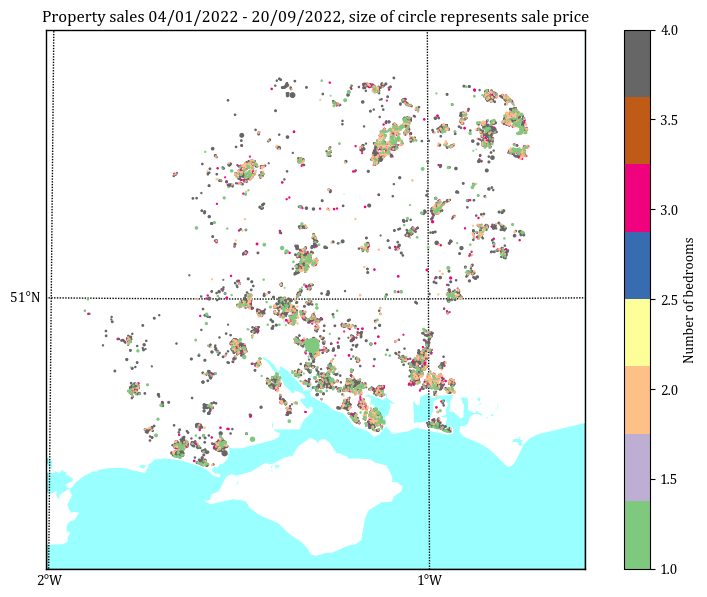

In [8]:
# let's make a geographical map of this dataset to see if we can visually spot any interesting insights
lon = df['long'].values
lat = df['lat'].values
area = df['nbr_bedrooms'].values
population = df['price_paid'].values

base_map_plot(sdata=population/1000000,bar=True,
              title="Property sales 04/01/2022 - 20/09/2022, size of circle represents sale price")

From the map we can see that most of the sales are in clusters - around the towns/cities. We can see that Southampton and Portsmouth (main city areas) are absent - this would be because they are covered by their own unitary authority.

We can visualise some of these clusters by e.g. focusing on a property type and looking at areas where the price paid was roughly the same.

Text(0.5, 1.0, 'Where do you pay similar prices for detached properties? 10 examples')

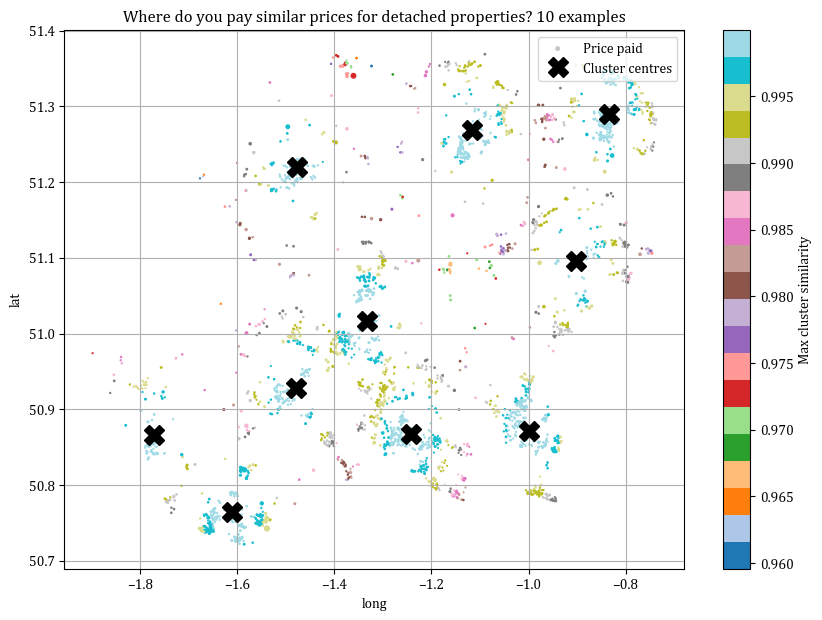

In [9]:
# get clusters for map
df_detach = df[df['property_type']=="Detached"]
df_detach = df_detach.dropna()
n_clus=10
cluster_simil = ClusterSimilarity(n_clusters=n_clus, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(df_detach[["lat", "long"]],
                                           sample_weight=df_detach['mean_price'])

df_detach["Max cluster similarity"] = similarities.max(axis=1)

df_detach.plot(kind="scatter", x="long", y="lat", grid=True,
                     s=df_detach ["price_paid"] / 1000000, label="Price paid",
                     c="Max cluster similarity",
                     cmap="tab20", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=15,
         label="Cluster centres")
plt.legend(loc="upper right")
plt.title("Where do you pay similar prices for detached properties? "+str(n_clus)+" examples")

We can see that the (10) clusters roughly match the towns/cities. Let's now focus on using some of the created columns to draw additional insight.

For starters let's take a look at the difference between the mean property price by town and the overall mean price by property

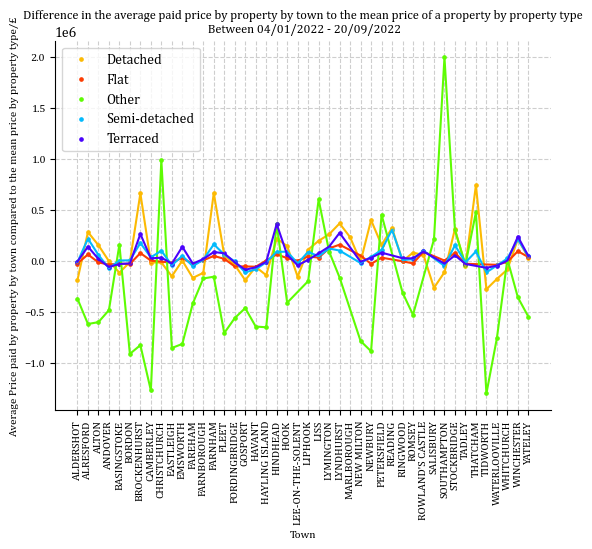

In [10]:
df_to_use = df1_count
line_graph(x='town',y='diff_mean_price',xlabel="Town",
           ylabel='Average Price paid by property by town compared to the mean price by property type/£',
           title='Difference in the average paid price by property by town to the mean price of a property by property type\n Between 04/01/2022 - 20/09/2022')


Look's like the property_type "Other" may influence things a bit - how does the same view look if we remove it?

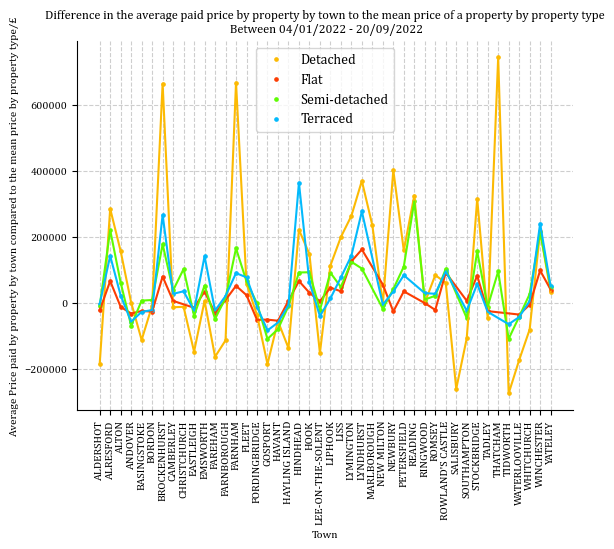

In [11]:
# let's get the data of interest
df1_count = df1_count[df1_count['property_type']!='Other'] # filter out the property_type "Other"

# now let's graph it
df_to_use = df1_count
line_graph(x='town',y='diff_mean_price',xlabel="Town",
           ylabel='Average Price paid by property by town compared to the mean price by property type/£',
           title='Difference in the average paid price by property by town to the mean price of a property by property type\n Between 04/01/2022 - 20/09/2022')

Now we're getting somewhere! It looks like the town's situated closer to London have a paid price (sale price) higher than the average of the dataset as a whole. That's perhaps not surprising, given demand-and-supply and also the typically higher wages that working in London affords.

Additionally, we can also see some areas which are typically below the average property type price - some of these will be due to their location (lack of jobs nearby, lack of amenities etc.) but also the type of houses available. E.g. in Gosport, most properties are terraced, flats or semi-detached. The detached houses that do exist will not be your typical 3/4 or more bedroom house. These factors together mean it is not surprising to see average town property type prices below the property type price average.

What about the cumulative paid prices by property type overall?
Excellent question - let's take a look:

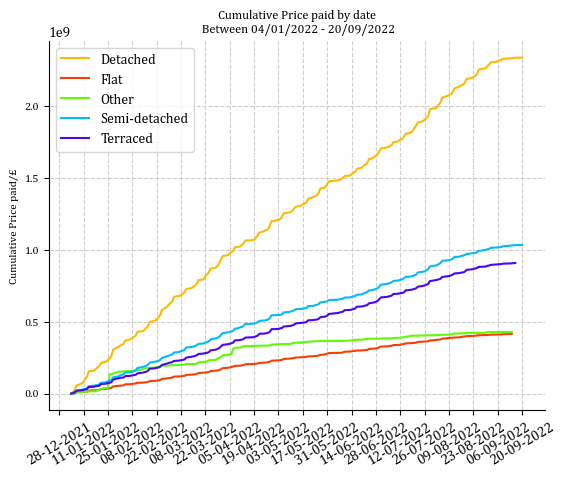

In [12]:
# let's get the data of interest
df1_count = df1.groupby(['property_type','deed_date'])['price_paid'].sum().reset_index()
df1_count['cprice']=df1_count.groupby(['property_type'])['price_paid'].cumsum()

# cumulative price paid graph
df_to_use = df1_count

line_graph_special(x='deed_date',y='cprice',
                   xlabel='Date',ylabel='Cumulative Price paid/£',
                   title='Cumulative Price paid by date\n Between 04/01/2022 - 20/09/2022',
                   labels=False)

Perhaps unsurprisingly, detached properties seem to contribute the most to the overall price paid (sale price)
Does the same narrative hold in terms of the number of sales of properties? - let's find out:

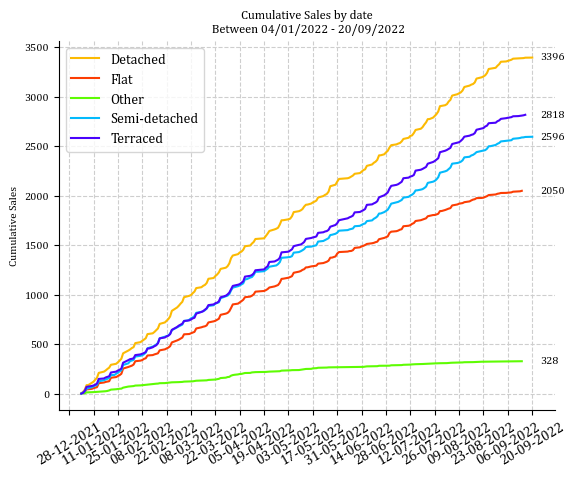

In [13]:
# let's get the data of interest
df1_count = df1.groupby(['property_type','deed_date'])['price_paid'].count().reset_index()
df1_count['cprice']=df1_count.groupby(['property_type'])['price_paid'].cumsum()


#cumulative sales graph
df_to_use = df1_count

line_graph_special(x='deed_date',y='cprice',
                   xlabel='Date',ylabel='Cumulative Sales',
                   title='Cumulative Sales by date\n Between 04/01/2022 - 20/09/2022',
                   labels=True)

As the popular meme goes: "Well yes, but actually no". 
Whilst the detached property type retains 1st place, the other property types all change position.

By having the knowledge of both graphs - some things become clear:

Detached houses sell for a lot of money - despite the number of sales not being hugely dissimilar to other property types, their overall price paid (for detached houses) is significantly higher than any other.

Some, if not all, of "Other" property types must also sell for a lot of money. This is because despite having a very small sales number (328), the overall paid price is a lot more. They actually finish above the flats overall paid price, despite being 1,722 smaller in number of sales.

That's great and all but what can we see if we go back to looking at things by town?

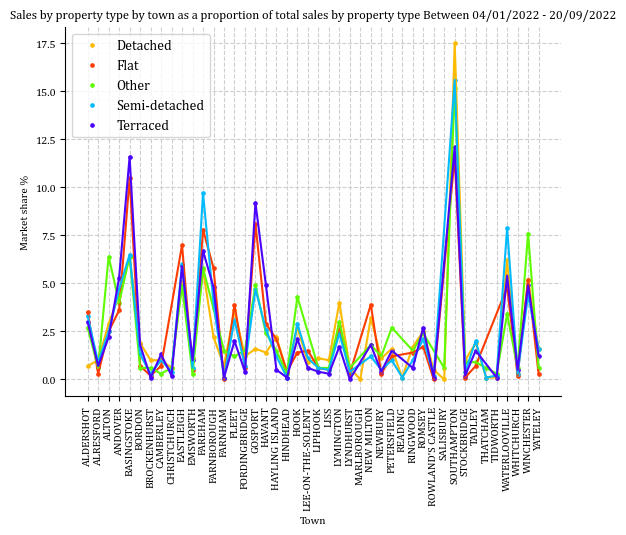

In [14]:
# let's get the data of interest - dataset 1 - number of sales by property type by town
df1_count = df1.groupby(['property_type','town'])['price_paid'].count().reset_index()
df1_count.rename(columns={'price_paid':'sales'},inplace=True)

# let's get the data of interest - dataset 2 - number of sales by property type
df1_counter = df1.groupby(['property_type'])['price_paid'].count().reset_index()
df1_counter.rename(columns={'price_paid':'total_sales_prop_type'},inplace=True)

# join these together
df1_count = pd.merge(df1_count,df1_counter,how="left",on=['property_type'])

# get market share percentage - the number of sales of a property type by town divided by the overall number of sales by property type
df1_count['mrkt_share'] = round((df1_count['sales']/df1_count['total_sales_prop_type'])*100,1)

# get market share percentage graph
df_to_use = df1_count

line_graph(x='town',y='mrkt_share',xlabel="Town",
           ylabel='Market share %',
           title='Sales by property type by town as a proportion of total sales by property type Between 04/01/2022 - 20/09/2022')


From a Sales number perspective, it looks like Basingstoke and Southampton contribute quite significantly to the overall picture for all property types.

What about the sum of the price paid by town by property type, how does this compare to the average by the property type? Let's find out:

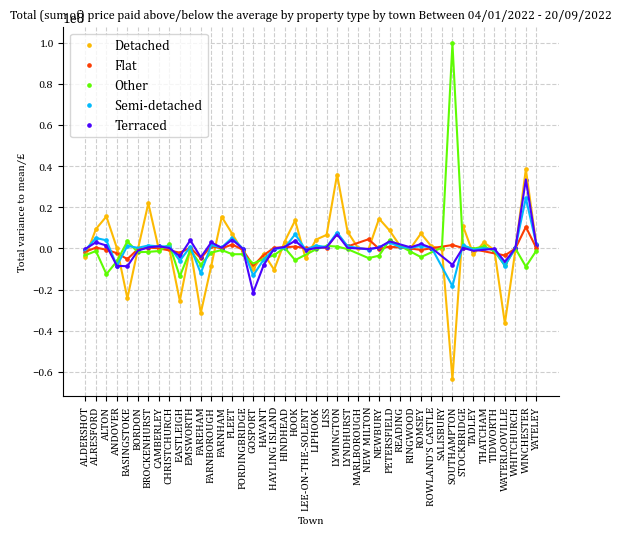

In [15]:
# let's get the data of interest
df1_count = df1.groupby(['property_type','town'])['price_diff'].sum().reset_index()

# visualise the data
df_to_use = df1_count

line_graph(x='town',y='price_diff',xlabel="Town",
           ylabel='Total variance to mean/£',
           title='Total (sum of) price paid above/below the average by property type by town Between 04/01/2022 - 20/09/2022')

In simple terms, the graph above is showing how the total difference in price paid by town by property type differs to the average of the price paid for that property type (has the town price paid being over or under on that property type when compared to the price paid property type average?)

Most striking is the significant over-spend for Southampton on the "Other" property type. This could be the one-off sale of a retail unit or estate, or a complex of shops/offices.

For most other towns and property types, there is a "slight" (+/- 0.4 *10^8 swing either way above or below).

Finally, how does the price paid, or number of sales by property type by town vary? Are the sales of a particular property type for that town many times more significant than the price_paid by property type by town?

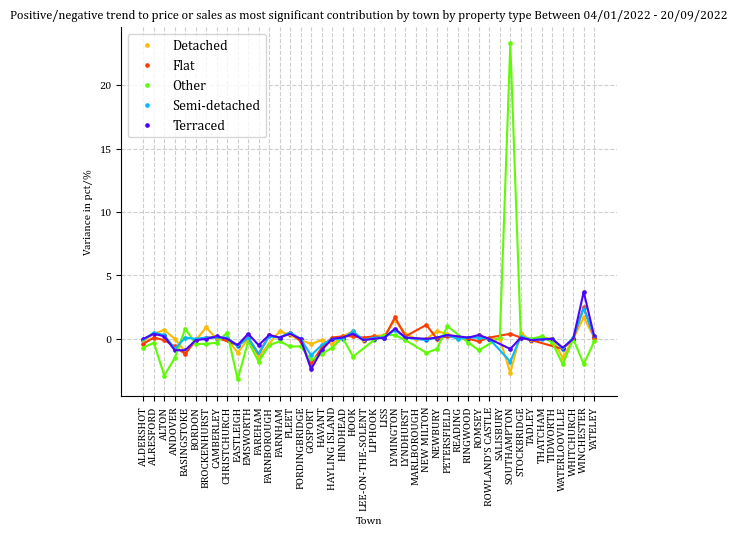

In [16]:
# get pct by town for total price_paid and total sales
df_sales_town = df1.groupby(['property_type','town'])['price_paid'].sum().reset_index()

df_sales_town_type = df1.groupby(['property_type'])['price_paid'].sum().reset_index()
df_sales_town_type.rename(columns={'price_paid':'total_paid_prop'},inplace=True)

# re-join
df_sales_town = pd.merge(df_sales_town, df_sales_town_type, how="left",on=['property_type'])

df_sales_town['pct'] = round((df_sales_town['price_paid']/df_sales_town['total_paid_prop'])*100,1)
df_sales_town = df_sales_town.sort_values(by=['pct'],ascending=False)
df_sales_town.rename(columns={'price_paid':'total_paid','pct':'pct_price_paid'},inplace=True)

df_cntsales_town = df1.groupby(['property_type','town'])['price_paid'].count().reset_index()

df_cntsales_town_type = df1.groupby(['property_type'])['price_paid'].count().reset_index()
df_cntsales_town_type.rename(columns={'price_paid':'total_sales_prop'},inplace=True)

# re-join
df_cntsales_town = pd.merge(df_cntsales_town, df_cntsales_town_type, how="left",on=['property_type'])


df_cntsales_town['pct'] = round((df_cntsales_town['price_paid']/df_cntsales_town['total_sales_prop'])*100,1)
df_cntsales_town = df_cntsales_town.sort_values(by=['pct'],ascending=False)
df_cntsales_town.rename(columns={'price_paid':'total_sales','pct':'pct_sales'},inplace=True)

# join together

df_pct = pd.merge(df_sales_town,df_cntsales_town,how="left",on=['property_type','town'])

# get pct difference (price to sales - +ve means higher impact on price, -ve means higher impact on sales)
df_pct['variance'] = df_pct['pct_price_paid'] - df_pct['pct_sales']
df_pct = df_pct.sort_values(by=['property_type','town'])

# graph this
df_to_use=df_pct
line_graph(x='town',y='variance',xlabel="Town",
           ylabel='Variance in pct/%',
           title='Positive/negative trend to price or sales as most significant contribution by town by property type Between 04/01/2022 - 20/09/2022')

A positive number in this instance means a stronger trend towards being paid price favourable, whilst a negative number means that of that town's property type, it has more of a market share of the number of sales as opposed to the paid price.

This can also be seen as a datatable:

In [17]:
df_pct

,property_type,town,total_paid,total_paid_prop,pct_price_paid,total_sales,total_sales_prop,pct_sales,variance
158,Detached,ALDERSHOT,11602275,2339952903,0.5,23,3396,0.7,-0.2
96,Detached,ALRESFORD,32183900,2339952903,1.4,33,3396,1.0,0.4
43,Detached,ALTON,83793955,2339952903,3.6,99,3396,2.9,0.7
31,Detached,ANDOVER,102893105,2339952903,4.4,149,3396,4.4,0.0
25,Detached,BASINGSTOKE,125253897,2339952903,5.4,217,3396,6.4,-1.0
...,...,...,...,...,...,...,...,...,...
196,Terraced,TIDWORTH,517500,909687798,0.1,2,2818,0.1,0.0
28,Terraced,WATERLOOVILLE,42902915,909687798,4.7,153,2818,5.4,-0.7
155,Terraced,WHITCHURCH,4609000,909687798,0.5,14,2818,0.5,0.0
7,Terraced,WINCHESTER,78416450,909687798,8.6,139,2818,4.9,3.7
